## Import Statements

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import ttest_ind_from_stats
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as st
import statsmodels.api as sm
from operator import itemgetter
from sklearn.metrics import mean_squared_error

### Reading data and naming columns

In [2]:
data = pd.read_excel("CCPP.xlsx")
data.columns = ['Ambi_Temp', 'Vac', 'Ambi_Press', 'Rel_Humidity', 'Electrical_Output']

## (b) Exploring the data

### i) Rows and Columns

In [3]:
print("Number of rows: ", len(data))
print("Number of columns: ", len(data.columns))
print("Columns : ", data.columns)

Number of rows:  9568
Number of columns:  5
Columns :  Index(['Ambi_Temp', 'Vac', 'Ambi_Press', 'Rel_Humidity', 'Electrical_Output'], dtype='object')


### There are 9568 rows and 5 columns in the dataset. The rows represent the entities or observations. Every columns describes an attribute of a certain type for the observations.

### ii) Pairwise scatterplots and inferences

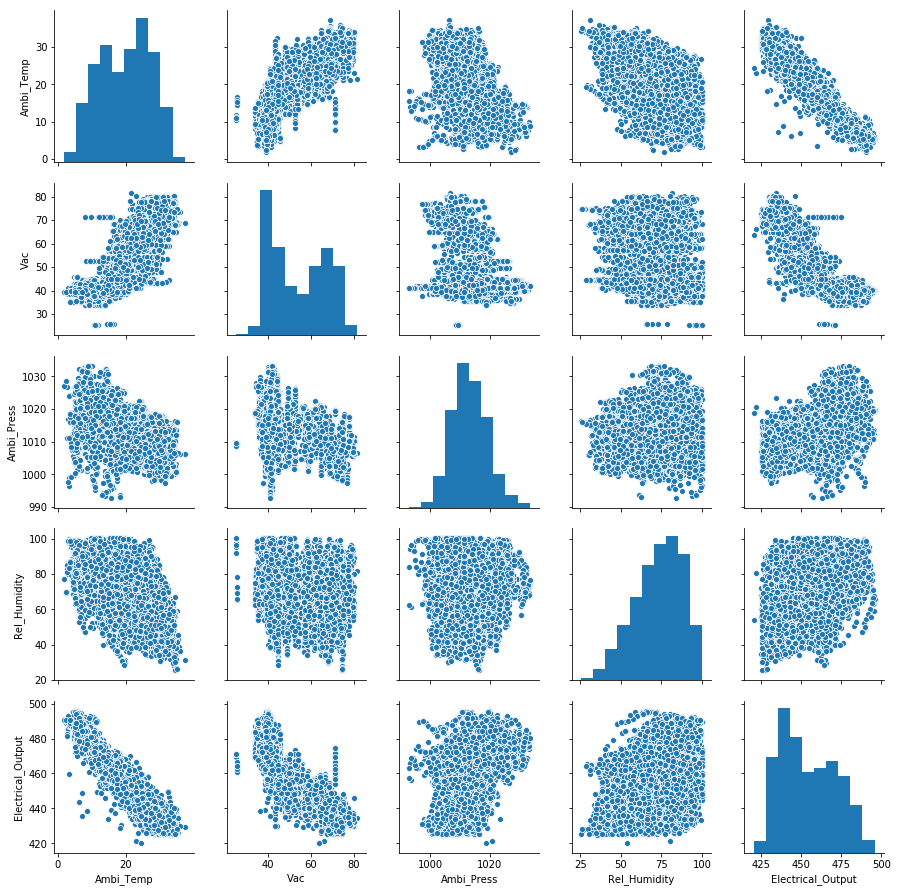

In [4]:
sns.pairplot(data)

### From the above graphs, there is clear co-relation between 3 variables - Volume, Ambient Temperature and Electrical Energy Ouput. 
- There is a high negative relation between Electrical Energy Output and Temperature, and also a high negative corelation between Electrical Energy Output and Volume. 
- By default this means that Temperature and Volume are positively corelated. Below co-relation values confirm the inference.

In [5]:
print("Co-Relation between Ambient Temperature and Elcetrical Output: ", np.corrcoef(data.Ambi_Temp, data.Electrical_Output)[0][1])
print("Co-Relation between Vacuum and Elcetrical Output: ", np.corrcoef(data.Vac, data.Electrical_Output)[0][1])

Co-Relation between Ambient Temperature and Elcetrical Output:  -0.9481284704167593
Co-Relation between Vacuum and Elcetrical Output:  -0.8697803096577885


### iii) Summarizing information about all the attributes

In [6]:
summary_table = pd.DataFrame(columns = ['Attribute Name','Mean','Median','Range','First Quartile','Third Quartile','Interquartile Range'])

In [7]:
for attribute in data.columns:
    quartiles = data[attribute].quantile([0.25, 0.75]).values
    summary_table.loc[len(summary_table)] = [attribute, data[attribute].mean(), data[attribute].median(),
                                             data[attribute].max() - data[attribute].min(), quartiles[0], quartiles[1],
                                             quartiles[1] - quartiles[0]]
summary_table

,Attribute Name,Mean,Median,Range,First Quartile,Third Quartile,Interquartile Range
0,Ambi_Temp,19.651231,20.345,35.30,13.5100,25.72,12.2100
1,Vac,54.305804,52.080,56.20,41.7400,66.54,24.8000
2,Ambi_Press,1013.259078,1012.940,40.41,1009.1000,1017.26,8.1600
3,Rel_Humidity,73.308978,74.975,74.60,63.3275,84.83,21.5025
4,Electrical_Output,454.365009,451.550,75.50,439.7500,468.43,28.6800


## (c) Liner Regression Models

### Making a general linear regressor model making function

                            OLS Regression Results                            
Dep. Variable:      Electrical_Output   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                 8.510e+04
Date:                Mon, 24 Sep 2018   Prob (F-statistic):               0.00
Time:                        21:45:22   Log-Likelihood:                -29756.
No. Observations:                9568   AIC:                         5.952e+04
Df Residuals:                    9566   BIC:                         5.953e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    497.0341      0.156   3177.280      0.0

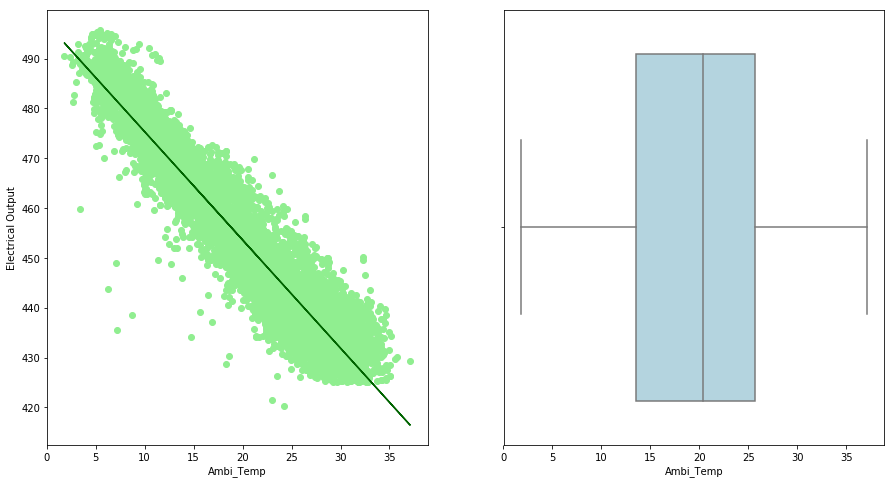

                            OLS Regression Results                            
Dep. Variable:      Electrical_Output   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                 2.972e+04
Date:                Mon, 24 Sep 2018   Prob (F-statistic):               0.00
Time:                        21:45:22   Log-Likelihood:                -33963.
No. Observations:                9568   AIC:                         6.793e+04
Df Residuals:                    9566   BIC:                         6.794e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    517.8015      0.378   1370.218      0.0

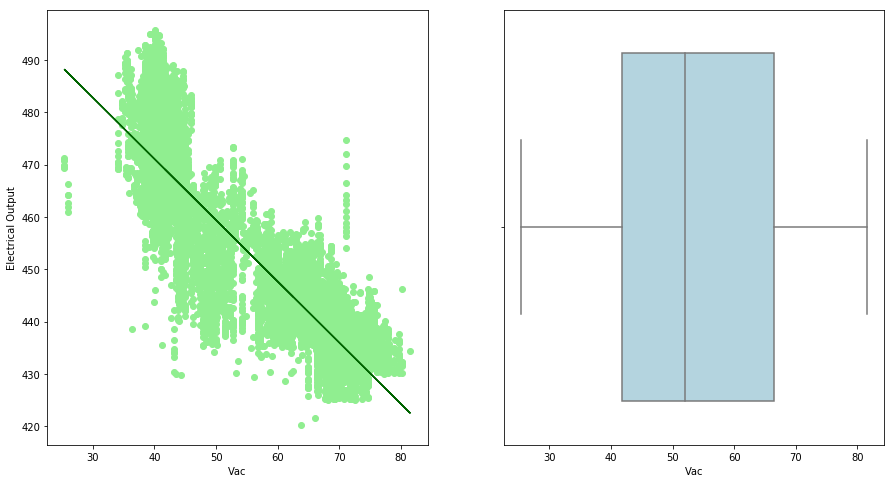

                            OLS Regression Results                            
Dep. Variable:      Electrical_Output   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     3516.
Date:                Mon, 24 Sep 2018   Prob (F-statistic):               0.00
Time:                        21:45:23   Log-Likelihood:                -39224.
No. Observations:                9568   AIC:                         7.845e+04
Df Residuals:                    9566   BIC:                         7.847e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1055.2610     25.459    -41.449      0.0

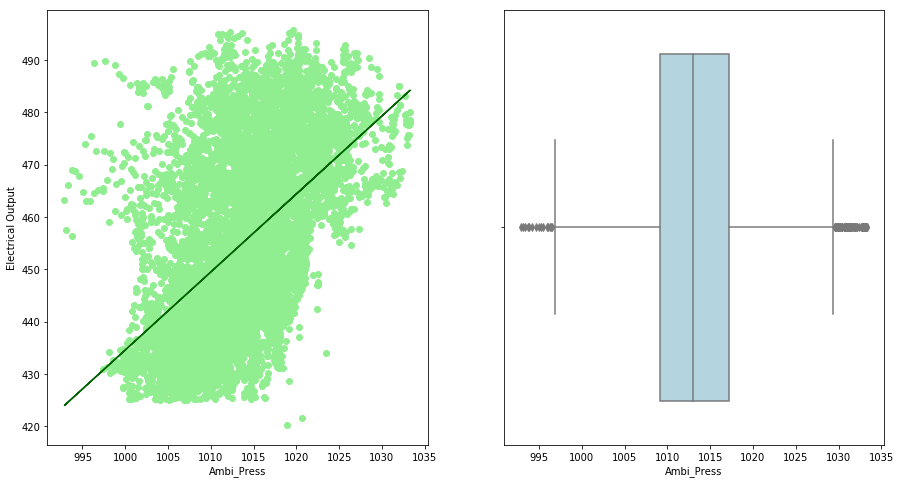

                            OLS Regression Results                            
Dep. Variable:      Electrical_Output   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     1714.
Date:                Mon, 24 Sep 2018   Prob (F-statistic):               0.00
Time:                        21:45:23   Log-Likelihood:                -39933.
No. Observations:                9568   AIC:                         7.987e+04
Df Residuals:                    9566   BIC:                         7.988e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      420.9618      0.823    511.676   

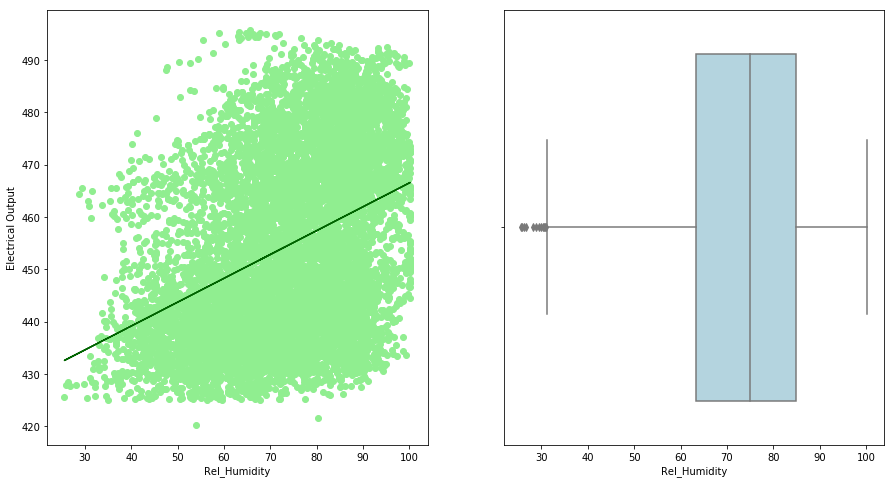

In [8]:
single_lr_coef = []
r_squared = {}
p_values = {}
Y = data.Electrical_Output
for attribute in data.columns[0:4]:
    ols = st.ols(formula = "Electrical_Output~"+attribute, data = data)
    lr = ols.fit()
    p = lr.params
    r_squared[attribute] = lr.rsquared
    p_values[attribute] = lr.pvalues
    single_lr_coef.append(p[attribute])
    print(lr.summary())
    plt.figure(figsize=(15,8))
    plt.subplot(1,2,1)
    plt.scatter(x = data[attribute], y = Y, color = "lightgreen")
    plt.plot(data[attribute], p.Intercept + p[attribute] * data[attribute], color = "darkgreen")
    plt.xlabel(attribute)
    plt.ylabel("Electrical Output")
    plt.subplot(1,2,2)
    sns.boxplot(data[attribute], color = "lightblue")
    plt.show()

In [9]:
for key in r_squared.keys():
    print(key + " : " + str(r_squared[key]))

Ambi_Temp : 0.8989475964148236
Vac : 0.7565177870683979
Ambi_Press : 0.2687686564110675
Rel_Humidity : 0.15193944023117545


In [10]:
for key in p_values.keys():
    print(key + " : " + str(p_values[key]))

Ambi_Temp : Intercept    0.0
Ambi_Temp    0.0
dtype: float64
Vac : Intercept    0.0
Vac          0.0
dtype: float64
Ambi_Press : Intercept     0.0
Ambi_Press    0.0
dtype: float64
Rel_Humidity : Intercept       0.0
Rel_Humidity    0.0
dtype: float64


### We can infer from the above R Squared values and P values that:
- Even though not all predictors show a clear linear relation, the p values for all are extremely low to consider any  any of them insignificant.
- Ambient Temperature and Vacuum can explain and fit our data really well.
- Ambient Pressure and Relative Humidity don't explain the data that well and the linear regression line is vague.
- We can observe from the boxplots that there are outliers for Ambient Pressure and Relative Humidity which can be removed to improve the model.

## (d) Multiple Linear Regression Model

In [11]:
ols = st.ols(formula = "Electrical_Output~Ambi_Temp+Vac+Ambi_Press+Rel_Humidity", data = data)
lr = ols.fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Electrical_Output   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Mon, 24 Sep 2018   Prob (F-statistic):               0.00
Time:                        21:45:23   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      454.6093      9.749     46.634      0.000     435.500     473.718
Ambi_Temp       -1.9775      0.015   -129.342      0.000      -2.007      -1.948
Vac             -0.2339      0.007    -32.122      0.000      -0.248      -0.220
Ambi_Press       0.0621      0.009      6.564      0.000       0.044       0.081
Rel_Humidity    -0.1581      0.004    -37.918      0.000      -0.166      -0.150
==============================================================================
Omnibus:                      892.002   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4086.777
Skew:                          -0.352   Prob(JB):                         0.00
Kurtosis:                       6.123   Cond. No.                     2.13e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### We can see from the above summary table that the P Values for all the attributes are extremely low. Hence, we can reject the null hypothesis for all the attributes.

## (e) Multiple Linear Regression VS Single Linear Regression 

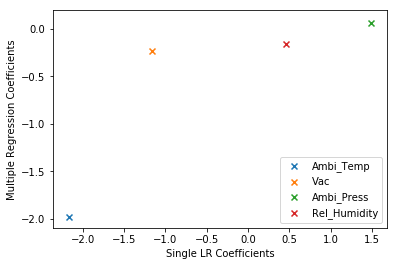

In [12]:
for i in range(len(data.columns[0:4])):
    plt.scatter(single_lr_coef[i], lr.params[i+1], label = data.columns[i], marker = "x")
plt.xlabel("Single LR Coefficients")
plt.ylabel("Multiple Regression Coefficients")
plt.legend()

### The R-Squared value for the multiple linear regression model is higher that any of the single linear regession models. Hence, we can say that the multiple linear regression model performs better when all attributes are considered.

### f) Checking for non-linear associations

SUMMARY FOR :  Ambi_Temp                             OLS Regression Results                            
Dep. Variable:                     EP   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 3.299e+04
Date:                Mon, 24 Sep 2018   Prob (F-statistic):               0.00
Time:                        21:45:24   Log-Likelihood:                -29101.
No. Observations:                9568   AIC:                         5.821e+04
Df Residuals:                    9564   BIC:                         5.824e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    492.7281      

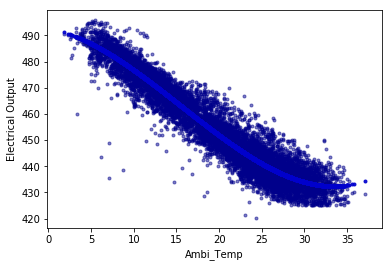

SUMMARY FOR :  Vac                             OLS Regression Results                            
Dep. Variable:                     EP   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                 1.098e+04
Date:                Mon, 24 Sep 2018   Prob (F-statistic):               0.00
Time:                        21:45:24   Log-Likelihood:                -33585.
No. Observations:                9568   AIC:                         6.718e+04
Df Residuals:                    9564   BIC:                         6.721e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    554.1468      9.151 

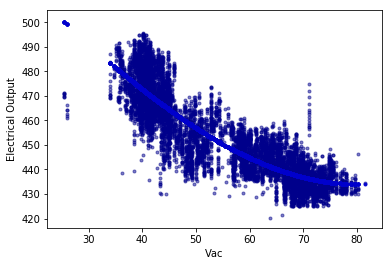

SUMMARY FOR :  Ambi_Press                             OLS Regression Results                            
Dep. Variable:                     EP   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     1813.
Date:                Mon, 24 Sep 2018   Prob (F-statistic):               0.00
Time:                        21:45:24   Log-Likelihood:                -39184.
No. Observations:                9568   AIC:                         7.837e+04
Df Residuals:                    9565   BIC:                         7.840e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0747     

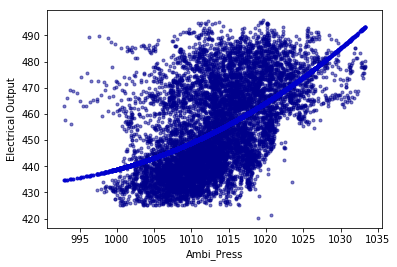

SUMMARY FOR :  Rel_Humidity                             OLS Regression Results                            
Dep. Variable:                     EP   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     579.2
Date:                Mon, 24 Sep 2018   Prob (F-statistic):               0.00
Time:                        21:45:25   Log-Likelihood:                -39923.
No. Observations:                9568   AIC:                         7.985e+04
Df Residuals:                    9564   BIC:                         7.988e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    468.4135   

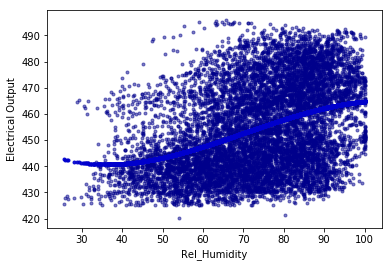

<Figure size 432x288 with 0 Axes>

In [13]:
for columns in data.columns[0:4]:
    new_data = pd.DataFrame()
    new_data['Linear'] = data[columns]
    new_data['Quadratic'] = data[columns]**2
    new_data['Cube'] = data[columns]**3
    new_data['EP'] = data.Electrical_Output
    ols = st.ols(formula = "EP~Linear+Quadratic+Cube", data = new_data)
    lr = ols.fit()
    p = lr.params
    Y = p.Intercept + p['Linear']*new_data['Linear'] + p['Quadratic']*new_data['Quadratic'] + p['Cube']*new_data['Cube']
    print("SUMMARY FOR : ", columns ,lr.summary())
    plt.scatter(data[columns], data.Electrical_Output, alpha=0.5, color = "darkblue", marker = ".")
    plt.scatter(new_data['Linear'],Y, marker = ".", color = 'mediumblue', alpha = 0.9)
    plt.xlabel(columns)
    plt.ylabel("Electrical Output")
    plt.show()
    plt.figure()

### According to the above P values : 
- There is a high non-linear association between 3 of the predictors and the response: Relative Humidity, Ambient Pressure and Ambient Temperature.
- For Volume, the quadratic term is highly insignificant, but the cubic term seems to be significant.

## g) Checking interactions between predictors with the response

In [14]:
formula = 'Electrical_Output~Ambi_Temp+Rel_Humidity+Ambi_Press+Vac+Ambi_Temp*Rel_Humidity+Rel_Humidity*Ambi_Press+Ambi_Press*Vac+Rel_Humidity*Vac+Ambi_Temp*Vac+Ambi_Press*Ambi_Temp'
ols = st.ols(formula, data)
lr = ols.fit()
p = lr.params
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:      Electrical_Output   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Mon, 24 Sep 2018   Prob (F-statistic):               0.00
Time:                        21:45:25   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

### According to the above summary table:
- Significant interaction terms: 
    -  Ambi_Temp:Rel_Humidity
    -  Ambi_Press:Vac
    -  Rel_Humidity:Ambi_Press
    -  Ambi_Temp:Vac
    
- Insignificant interaction terms:
    -  Rel_Humidity:Vac  
    -  Ambi_Press:Ambi_Temp

## (h) Regression Model with all predictors vs Regression Model with interaction and quadratic terms

### Splitting data into test and train

In [15]:
train_X, test_X, train_Y, test_Y = train_test_split(data[data.columns[:len(data.columns)-1]], data.Electrical_Output, test_size = 0.3, random_state = 40)
train = pd.concat([train_X, train_Y], axis=1)

### Testing Regression Model with all Simple Predictors

In [16]:
ols = st.ols("Electrical_Output~Ambi_Temp+Vac+Ambi_Press+Rel_Humidity", train)
lr = ols.fit()
print("FOR SIMPLE MODEL")
print("Train MSE : ", lr.mse_resid)
pred = lr.predict(test_X)
print("Test MSE : ", mean_squared_error(pred, test_Y))

FOR SIMPLE MODEL
Train MSE :  20.438022390437702
Test MSE :  21.605882405223724


### Testing Regression Model with all Complex Predictors

In [17]:
attributes = ['Ambi_Temp', 'Ambi_Press', 'Vac', 'Rel_Humidity']
interactions = ['Ambi_Temp:Ambi_Press','Ambi_Temp:Vac','Ambi_Temp:Rel_Humidity','Ambi_Press:Vac','Ambi_Press:Rel_Humidity','Vac:Rel_Humidity']
quadratic = ['I(Ambi_Temp ** 2)','I(Ambi_Press ** 2)','I(Vac ** 2)','I(Rel_Humidity ** 2)']

### Performing Backward Selection

In [18]:
passNumber = 0
fitAndBreak = False
while True:
    passNumber += 1
    equation = "Electrical_Output~"
    for attr in attributes:
        equation = equation+"+"+attr
    for attr in interactions:
        equation = equation+"+"+attr
    for attr in quadratic:
        equation = equation+"+"+attr
    ols = st.ols(equation, data = train)
    lr = ols.fit()
    if fitAndBreak == True:
        break
    p = lr.pvalues
    p = p.to_dict()
    p = sorted(p.items(), key=itemgetter(1))
    if p[-1][1] >= 0.05:
        print("In Pass Number : ", passNumber, ", "+ p[-1][0] + " has the highest P Value " +
              "(" + str(p[-1][1]) + ">0.05), hence we remove this attribute from our equation.")
        if p[-1][0] in interactions:
            interactions.remove(p[-1][0])
        elif p[-1][0] in quadratic:
            quadratic.remove(p[-1][0])
    else:
        firAndBreak = True
        break
print("Backward Selection Completed")
print("Attributes that should be considered are as follows : ")
print("Quadratic Terms : ", quadratic)
print("Interactions Terms : ", interactions)

In Pass Number :  1 , Vac:Rel_Humidity has the highest P Value (0.9408202029242914>0.05), hence we remove this attribute from our equation.
In Pass Number :  2 , I(Vac ** 2) has the highest P Value (0.29008688915130415>0.05), hence we remove this attribute from our equation.
In Pass Number :  3 , Ambi_Temp:Ambi_Press has the highest P Value (0.1334574454505456>0.05), hence we remove this attribute from our equation.
Backward Selection Completed
Attributes that should be considered are as follows : 
Quadratic Terms :  ['I(Ambi_Temp ** 2)', 'I(Ambi_Press ** 2)', 'I(Rel_Humidity ** 2)']
Interactions Terms :  ['Ambi_Temp:Vac', 'Ambi_Temp:Rel_Humidity', 'Ambi_Press:Vac', 'Ambi_Press:Rel_Humidity']


In [19]:
print("FOR COMPLEX MODEL")
print("Train MSE : ", lr.mse_resid)
pred = lr.predict(test_X)
print("Test MSE : ", mean_squared_error(pred, test_Y))
#lr.summary()

FOR COMPLEX MODEL
Train MSE :  17.859377747927233
Test MSE :  18.822734390481255


### Clearly, the Mean Squared Error with all the significant terms (obtained by Backward Selection) results in a slight decrease in the mean squared error. Hence, the model with selected interaction an quadratic terms performs much better.

## (i) KNN Regression

### Performing KNN Regression using raw features

In [20]:
dict_test_error = {}
dict_train_error = {}
train_X, test_X, train_Y, test_Y = train_test_split(data[data.columns[:len(data.columns)-1]], data.Electrical_Output, test_size = 0.3, random_state = 40)
for k in range(1, 101):
    knnregressor = KNeighborsRegressor(n_neighbors = k)
    knnregressor.fit(train_X, train_Y)
    dict_test_error[1/k] = 1 - knnregressor.score(test_X, test_Y)
    dict_train_error[1/k] = 1 - knnregressor.score(train_X, train_Y)
testK = 1/min(dict_test_error, key=dict_test_error.get)
print("Best Test Error: ", dict_test_error[1/testK])
print("Best K on Testing Set: ", testK)
trainK = 1/min(dict_train_error, key=dict_train_error.get)
print("Best Train Error: ", dict_train_error[1/trainK])
print("Best K on Training Set: ", trainK)
knnregressor = KNeighborsRegressor(n_neighbors = int(testK))
knnregressor.fit(train_X, train_Y)
pred = knnregressor.predict(test_X)
print("MSE for best K on testing set: ", mean_squared_error(pred, test_Y))

Best Test Error:  0.056940366326476255
Best K on Testing Set:  6.0
Best Train Error:  0.0
Best K on Training Set:  1.0
MSE for best K on testing set:  16.739065959402456


### Performing KNN using normalized feature set

In [21]:
from sklearn import preprocessing
dict_test_error = {}
dict_train_error = {}
normalized_data = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(data))
normalized_data.columns = data.columns
columns = normalized_data.columns
for k in range(1, 101):
    ntrain_X, ntest_X, ntrain_Y, ntest_Y = train_test_split(normalized_data[columns[:len(columns)-1]], normalized_data.Electrical_Output, test_size = 0.3, random_state = 42)
    knnregressor = KNeighborsRegressor(n_neighbors = k)
    knnregressor.fit(ntrain_X, ntrain_Y)
    dict_test_error[1/k] = 1 - knnregressor.score(ntest_X, ntest_Y)
    dict_train_error[1/k] = 1 - knnregressor.score(ntrain_X, ntrain_Y)
testK = 1/min(dict_test_error, key=dict_test_error.get)
print("Best Test Error: ", dict_test_error[1/testK])
print("Best K on Testing Set: ", testK)
trainK = 1/min(dict_train_error, key=dict_train_error.get)
print("Best Train Error: ", dict_train_error[1/trainK])
print("Best K on Training Set: ", trainK)
knnregressor = KNeighborsRegressor(n_neighbors = int(testK))
knnregressor.fit(ntrain_X, ntrain_Y)
print("MSE for best K on testing set: ", mean_squared_error(knnregressor.predict(ntest_X), ntest_Y))

Best Test Error:  0.04894484562993051
Best K on Testing Set:  4.0
Best Train Error:  0.0
Best K on Training Set:  1.0
MSE for best K on testing set:  0.002517197223700568


<Figure size 432x288 with 0 Axes>

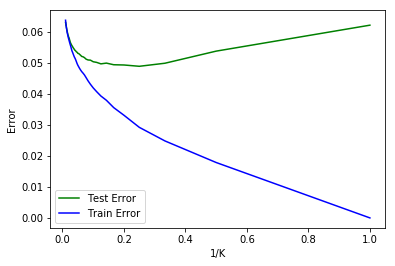

<Figure size 432x288 with 0 Axes>

In [22]:
plt.plot(dict_test_error.keys(), dict_test_error.values(), label = "Test Error",color = "g")
plt.plot(dict_train_error.keys(), dict_train_error.values(), label = "Train Error", color = "b")
plt.xlabel("1/K")
plt.ylabel("Error")
plt.legend()
plt.figure()

In [23]:
ols = st.ols("Electrical_Output~Ambi_Temp+Vac+Ambi_Press+Rel_Humidity", train)
lr = ols.fit()
print("FOR SIMPLE MODEL")
print("Train MSE : ", lr.mse_resid)
pred = lr.predict(test_X)
print("Test MSE : ", mean_squared_error(pred, test_Y))

FOR SIMPLE MODEL
Train MSE :  20.438022390437702
Test MSE :  21.605882405223724


## (j) Comparing results

### MSE for Simple Linear Regression : 21.605882405223724<br>MSE for Complex Multiple Linear Regression : 18.822734390481255<br>MSE for KNN with raw features : 16.739065959402456<br>MSE for KNN with normalized features : 0.002517197223700568

### From the above values, we can see that KNN Regression in general performs better for our case.